# Bankruptcy Prediction — End-to-End

**Goal:** Build a simple, robust classification model that predicts `Bankrupt?` using financial ratios. This notebook covers:
1. Loading data
2. Cleaning & validation
3. Feature selection
4. Exploratory Data Analysis (EDA)
5. Feature engineering & preprocessing
6. Model training, evaluation and saving
7. Creating prediction output (CSV)

**Notes**
- All file paths are relative to this notebook's folder.
- After running, `models/model.pkl` will be created.


### Importing Dependencies

In [38]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import pickle

%matplotlib inline
sns.set_theme()
plt.style.use('seaborn-v0_8-whitegrid') 


## LOADING THE DATA

In [39]:
df = pd.read_csv(r"C:\Users\jatin\OneDrive\Documents\bankruptcy_clean_final.csv")

print("Data loaded. Shape:", df.shape)
df.head()

#remove all spaces around column names
df.columns = df.columns.str.strip()


Data loaded. Shape: (6819, 36)


#### Quick Data Overview

In [40]:
# basic info
display(df.info())
display(df.describe().T)

# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 36 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Current Ratio                                       6819 non-null   float64
 1   Quick Ratio                                         6819 non-null   float64
 2   Working Capital to Total Assets                     6819 non-null   float64
 3   Quick Assets/Total Assets                           6819 non-null   float64
 4   Current Assets/Total Assets                         6819 non-null   float64
 5   Cash/Total Assets                                   6819 non-null   float64
 6   Debt ratio %                                        6819 non-null   float64
 7   Total debt/Total net worth                          6819 non-null   float64
 8   Liability to Equity                                 6819 non-null   float64
 9

None

,count,mean,std,min,25%,50%,75%,max
Current Ratio,6819.0,1.434227e-02,1.187274e-02,0.002390,7.555000e-03,1.058700e-02,1.626950e-02,7.459500e-02
Quick Ratio,6819.0,1.065402e-02,1.077341e-02,0.000408,4.726000e-03,7.412000e-03,1.224950e-02,6.586000e-02
Working Capital to Total Assets,6819.0,8.144005e-01,5.706115e-02,0.684405,7.743090e-01,8.102750e-01,8.503825e-01,9.597360e-01
Quick Assets/Total Assets,6819.0,3.998449e-01,2.007311e-01,0.040822,2.419730e-01,3.864510e-01,5.405935e-01,8.664960e-01
Current Assets/Total Assets,6819.0,5.224580e-01,2.170826e-01,0.085777,3.528450e-01,5.148300e-01,6.890505e-01,9.581490e-01
Cash/Total Assets,6819.0,1.231318e-01,1.347859e-01,0.002648,3.354300e-02,7.488700e-02,1.610730e-01,6.765460e-01
Debt ratio %,6819.0,1.128329e-01,5.183937e-02,0.014149,7.289100e-02,1.114070e-01,1.488045e-01,2.386670e-01
Total debt/Total net worth,6819.0,7.318396e-03,6.543581e-03,0.000493,3.007500e-03,5.546000e-03,9.273500e-03,3.933300e-02
Liability to Equity,6819.0,2.799960e-01,4.494830e-03,0.275102,2.769445e-01,2.787780e-01,2.814490e-01,3.000990e-01
Equity to Liability,6819.0,4.608274e-02,3.675429e-02,0.013800,2.447650e-02,3.379800e-02,5.283800e-02,2.339430e-01


Series([], dtype: int64)

## PREPROCESSING

#### 
Remove duplicates and ensure target column
- Remove exact duplicate rows
- Ensure `Bankrupt?` target exists and has only 0/1 or similar values


In [41]:
# drop exact duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows")

# Check target column
target_col = "Bankrupt?"
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found in data. Rename your target column accordingly.")
    
print("Target value counts:")
print(df[target_col].value_counts(dropna=False))


Dropped 0 duplicate rows
Target value counts:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


##  Feature selection
Using the curated list of most important features (numeric ratios and flags).
If any of these columns are missing in your CSV, the notebook will drop them and continue with available ones.


In [42]:
# final feature list
features = [
    "Current Ratio",
    "Quick Ratio",
    "Working Capital to Total Assets",
    "Quick Assets/Total Assets",
    "Current Assets/Total Assets",
    "Cash/Total Assets",
    "Debt ratio %",
    "Total debt/Total net worth",
    "Liability to Equity",
    "Equity to Liability",
    "Long-term Liability to Current Assets",
    "Operating Gross Margin",
    "Realized Sales Gross Margin",
    "Operating Profit Rate",
    "Net Income to Total Assets",
    "Net Income to Stockholder's Equity",
    "Cash flow rate",
    "CFO to Assets",
    "Cash Flow to Total Assets",
    "Cash Flow to Liability",
    "Cash Flow to Equity",
    "Cash Flow to Sales",
    "Total Asset Turnover",
    "Accounts Receivable Turnover",
    "Inventory Turnover Rate (times)",
    "Fixed Assets Turnover Frequency",
    "Interest Expense Ratio",
    "Interest Coverage Ratio (Interest expense to EBIT)",
    "Total Asset Growth Rate",
    "Net Value Growth Rate",
    "Operating Profit Growth Rate",
    "Realized Sales Gross Profit Growth Rate",
    "After-tax Net Profit Growth Rate",
    "Net Income Flag",
    "Liability-Assets Flag"
]

# Keep only features that exist in df
available_features = [f for f in features if f in df.columns]
missing_features = [f for f in features if f not in df.columns]

print(f"Available features: {len(available_features)} / {len(features)}")
if missing_features:
    print("Missing (will be ignored):", missing_features)

# Prepare X and y
X = df[available_features].copy()
y = df[target_col].copy()


Available features: 35 / 35


#### 
Handling missing values & simple validation
- Numeric features: fill with median
- Binary flags: fill with mode or 0 (safe)
- Drop rows where target is missing (already done)


In [43]:
# Separate numeric & non-numeric (should all be numeric, but just in case)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
other_cols = [c for c in X.columns if c not in num_cols]

# Fill numeric with median
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Fill other (rare) with mode or 0
for c in other_cols:
    if X[c].isnull().any():
        if X[c].dtype == 'object':
            X[c] = X[c].fillna(X[c].mode().iloc[0])
        else:
            X[c] = X[c].fillna(0)

print("Missing values after imputation:", X.isnull().sum().sum())


Missing values after imputation: 0


## EXPLORATORY DATA ANALYSIS

- Show target balance (Bankruptcy Class Distribution)
- Plot histograms for a few numeric features
- Show correlation heatmap (selected subset)


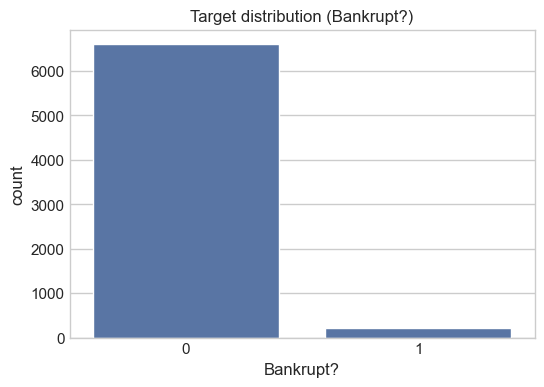

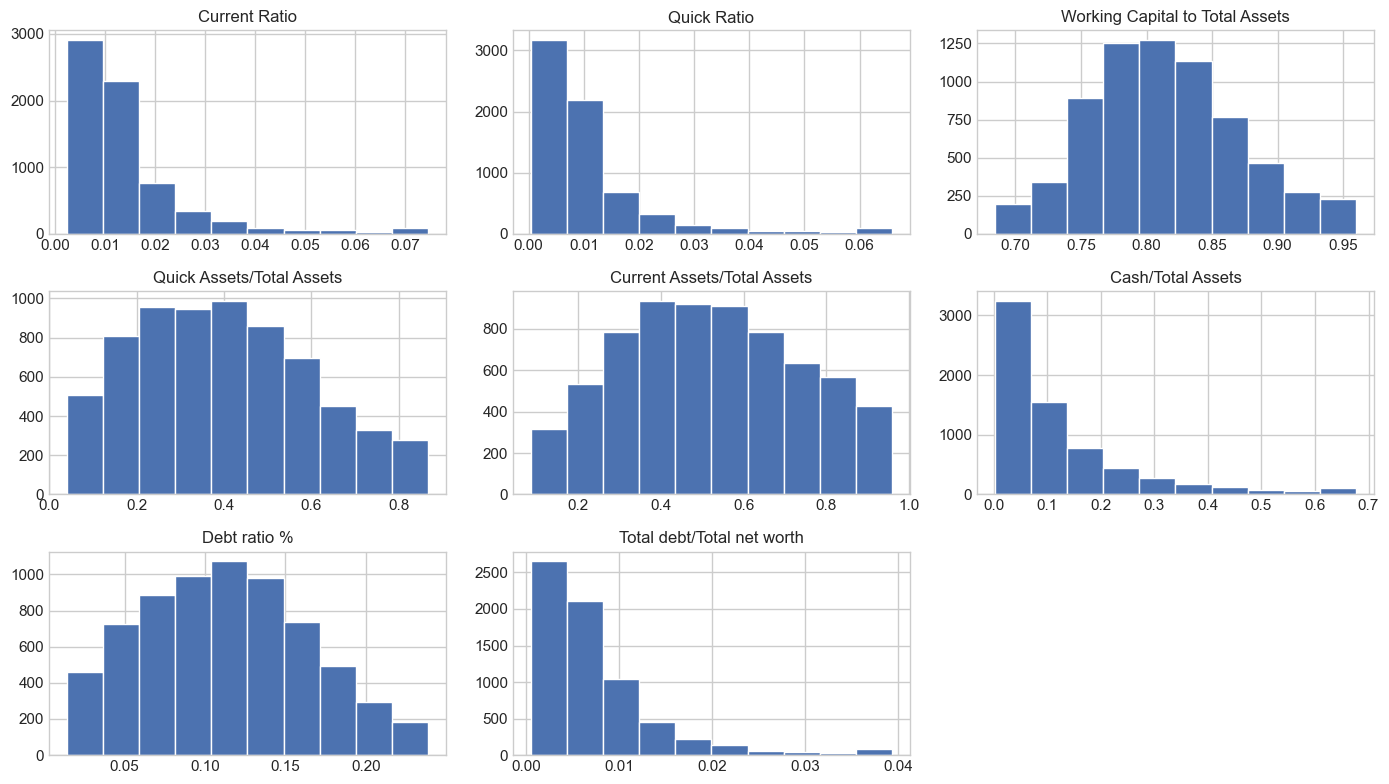

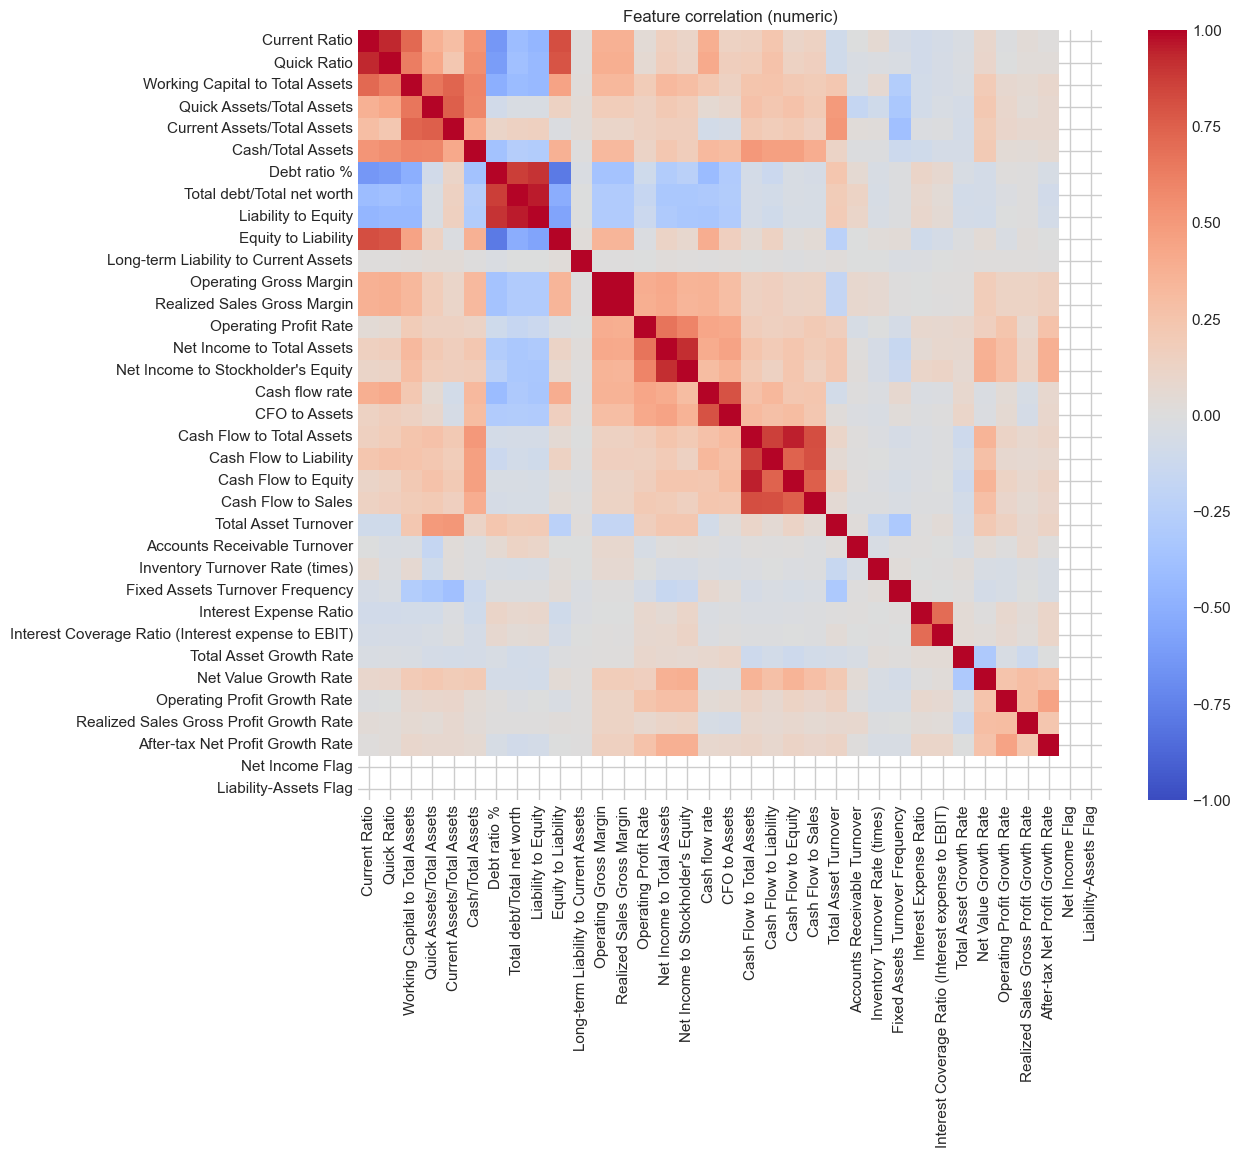

In [44]:
# Target balance
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Bankrupt?")
plt.title("Target distribution (Bankrupt?)")
plt.show()

# Histograms: sample of features (top 8 numeric)
if len(num_cols) > 0:
    sample_nums = num_cols[:8]
    X[sample_nums].hist(figsize=(14,8))
    plt.tight_layout()
    plt.show()
else:
    print("No numeric features to plot.")


# Correlation heatmap on available numeric features (limit to 30 to keep it readable)
corr = X[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=False)
plt.title("Feature correlation (numeric)")
plt.show()


#### Train-test split
- We reserve 20% test set. Use a fixed random_state for reproducibility.
- We use `stratify=y` to preserve the rare bankrupt class distribution

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))


Train shape: (5455, 35) Test shape: (1364, 35)
Train target distribution:
 Bankrupt?
0    0.967736
1    0.032264
Name: proportion, dtype: float64


#### Scale the Data
- We apply `StandardScaler` for consistent scale across all ratios

In [46]:
# SCALE FEATURES
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [47]:
if len(available_features) == 0:
    raise ValueError("No features found from `available_features`. Check column names in CSV.")

## MODEL TRAINING



In [48]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,               #For stability
    random_state=42,
    class_weight="balanced",    #To handle class imbalance
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### MODEL EVALUATION

In [49]:
# Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]
if len(np.unique(y_test)) == 1:
    print("ROC-AUC: only one class present in y_test — ROC not defined.")
else:
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


ROC-AUC: 0.9429665977961432


#### Plot Confusion Matrix

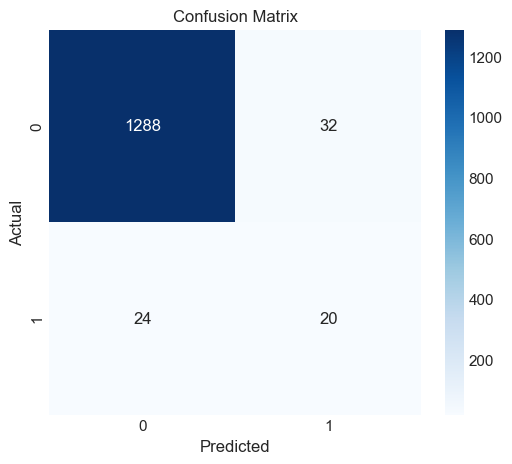

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Feature Importance

In [51]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances_sorted.head(20)

Net Income to Total Assets                            0.102180
Net Income to Stockholder's Equity                    0.082663
Debt ratio %                                          0.072519
Liability to Equity                                   0.070162
Total debt/Total net worth                            0.069314
Interest Expense Ratio                                0.061191
Equity to Liability                                   0.058088
Net Value Growth Rate                                 0.056762
Interest Coverage Ratio (Interest expense to EBIT)    0.044466
Quick Ratio                                           0.042643
Operating Profit Rate                                 0.030127
Current Ratio                                         0.025545
Working Capital to Total Assets                       0.022555
Accounts Receivable Turnover                          0.020598
Total Asset Turnover                                  0.019082
Cash/Total Assets                                     0

### Feature Importance Plot

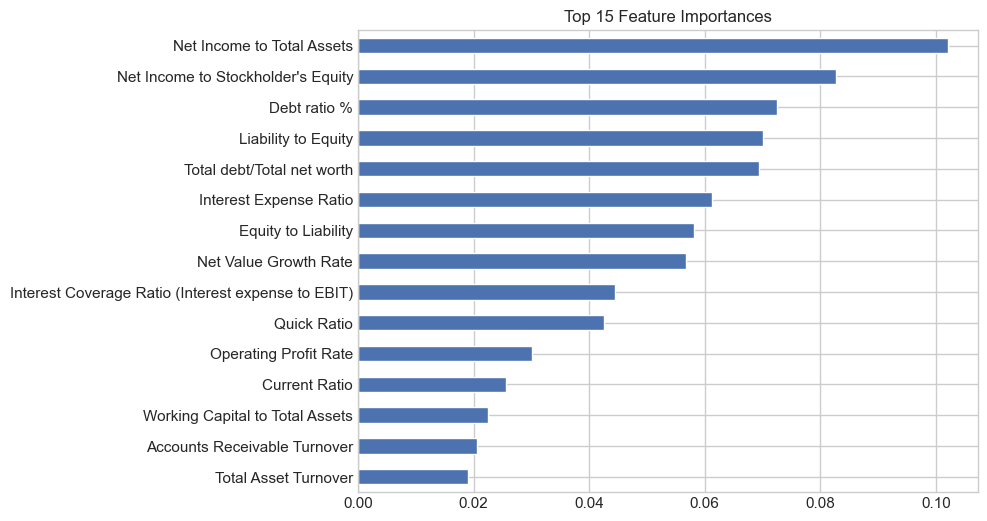

In [52]:
plt.figure(figsize=(8,6))
importances_sorted[:15].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.show()


## SAVING THE MODEL

In [53]:
import os
os.makedirs("models", exist_ok=True)

with open("models/model.pkl", "wb") as f:
    pickle.dump((rf, scaler, available_features), f)

print("Saved model to models/model.pkl")


Saved model to models/model.pkl


### Saving Predictions CSV

In [54]:
results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Probability": y_proba
})

results.to_csv("predictions.csv", index=False)
results.head()


,Actual,Predicted,Probability
0,0,0,0.015769
1,0,0,0.019825
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.016573


### Threshold Tuning

This will likely give:
- Recall > 0.60
- Lower precision
- Much safer detection


In [56]:
threshold = 0.30
y_pred_adj = (y_proba > threshold).astype(int)

print("Threshold 0.30")
print(classification_report(y_test, y_pred_adj))


Threshold 0.30
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1320
           1       0.36      0.64      0.46        44

    accuracy                           0.95      1364
   macro avg       0.68      0.80      0.72      1364
weighted avg       0.97      0.95      0.96      1364

